In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# jax
import jax.numpy as jnp
from jax import random
import time

# collocation
import sys
import os
p_ = os.path.abspath(os.path.join('..', '00_utils'))
if p_ not in sys.path:
    sys.path.append(p_)
    
import collocation_obj
import importlib

In [2]:
def f(x):
    return x * np.sin(x)
    # return np.sin(x)

def df(x):
    return np.sin(x) + x*np.cos(x)
    # return np.cos(x)

eval_pt = np.linspace(0, 2*np.pi, 100)
f_values = f(eval_pt)
df_analytical = df(eval_pt)
df_numerical = np.gradient(f_values, eval_pt)
error = np.linalg.norm(df_analytical - df_numerical)

print("Maximum error:", np.max(error))

Maximum error: 0.09501322546375748


In [4]:
import numpy as np
from scipy.special import roots_jacobi

# https://scicomp.stackexchange.com/questions/32918/need-an-example-legendre-gauss-radau-pseudospectral-differentiation-matrix-or-ma
def OCnonsymGLReig(n, meth, a=0.0, b=1.0, include_endpoints=True):
    # meth = 1,2,3,4 for Gauss, Lobatto, Radau (right), Radau (left)
    na = [1, 0, 0, 1]  # Defines alpha offset for the weight formula
    nb = [1, 0, 1, 0]  # Defines beta offset for the weight formula
    nt = n + 2 if include_endpoints else n

    # Adjust alpha and beta based on the method
    alpha = 1.0 - na[meth-1]
    beta = 1.0 - nb[meth-1]

    # Get roots and weights for the Jacobi polynomial
    roots, weights = roots_jacobi(n, alpha, beta)

    # Define the transformation for the points from [-1, 1] to [a, b]
    x = 0.5 * (roots + 1)  # First transform to [0, 1]
    x = a + (b - a) * x  # Then scale to [a, b]
    
    if include_endpoints:
        x = np.hstack(([a], x, [b]))  # Include a and b as endpoints

    # Compute the first derivative matrix A
    xdif = x[:, np.newaxis] - x
    np.fill_diagonal(xdif, 1)  # Avoid division by zero
    dpx = np.prod(xdif, axis=1)

    A = dpx[:, np.newaxis] / (dpx * xdif)
    np.fill_diagonal(A, 1 - np.sum(A, axis=1))

    return x, A

# Usage Example
n = 20
meth = 4  # For example, using Gauss
x, A = OCnonsymGLReig(n, meth, a=0.0, b=10.0, include_endpoints=True)


## Nodes

In [22]:
importlib.reload(collocation_obj)
Collocation = collocation_obj.Collocation

x_cheb = Collocation.chebyshev_nodes_second_kind(20, 0 , 10)
x_jacobi, D_jacobi = OCnonsymGLReig(20, 4, a=0.0, b=10.0, include_endpoints=True)
legendre = Collocation(20, 0, 10, "gauss_legendre", include_init = True)
x_leg = legendre.compute_nodes()

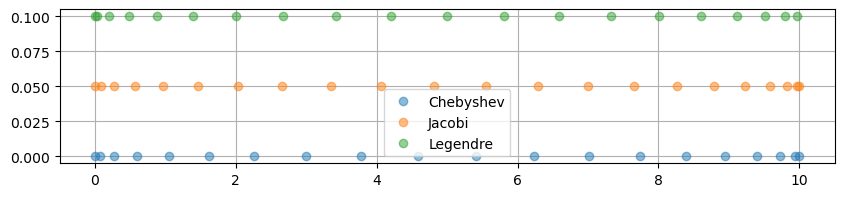

In [20]:
plt.figure(figsize=(10, 2))
plt.plot(x_cheb, np.zeros_like(x_cheb), 'o', label=f'Chebyshev', alpha = 0.5)
plt.plot(x_jacobi, np.ones_like(x_jacobi)/20, 'o', label=f'Jacobi', alpha = 0.5)
plt.plot(x_leg, np.ones_like(x_leg)/10, 'o', label=f'Legendre', alpha = 0.5)
plt.grid()
plt.legend()
plt.show();


In [25]:
def first_deriv(nodes):
    xdif = nodes[:, np.newaxis] - nodes
    np.fill_diagonal(xdif, 1)  # Avoid division by zero
    dpx = np.prod(xdif, axis=1)

    A = dpx[:, np.newaxis] / (dpx * xdif)
    np.fill_diagonal(A, 1 - np.sum(A, axis=1))
    return A

D_leg = first_deriv(x_leg) 

In [28]:
D_leg.shape

(20, 20)

In [29]:
dy_dt_jacobi = []
for i in range(len(x_jacobi)):
    dy_dt_jacobi.append(D_jacobi[i] @ f(x_jacobi))

dy_dt_leg = []
for i in range(len(x_leg)):
    dy_dt_leg.append(D_leg[i] @ f(x_leg))

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(x_leg, df(x_leg), color='red', label=f'Derivative Analytical')
plt.plot(x, dy_dt, '--', label=f'Derivative Numerical')
plt.title('Derivative of $f(x) = x \sin(x)$; Analytical vs. Numerical')
plt.grid()
plt.legend()
plt.show();

# error = np.mean((df(nodes) - dy_dt)**2)

print("Maximum error:", np.max(error))